# The Duffing Equation

In [1]:
import math
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

The full form of the Duffing Equation is as follows: $$ \ddot{x} + \delta \dot{x} + \beta x + \alpha x^3 = \gamma cos(\omega t)$$

Where: $\delta$ is the damping constant, $\alpha$ changes the linearity of the spring constant, $\beta$ adds restoring force, $\gamma$ changed the amplitude of the driving force, and $\omega$ is the angular frequency.

Three ways of integration will be used, and their time compared. We've already compared their accuracy, but when many many particles need to be evaulated (like in a particle matrix), then as long as there's good accuracy at high resolution, then high resolution should be used as long as its not computationally expencive.

Their main differences include that the RK4 algorithm is the most accurate but also supposedly more computationally expencive, and that the Verlet and Beeman algorithms produce the same paths but the Beeman algorithm has more accurate velocities.

In [2]:
def RK_four(F,x_not,dt,N):
    time_vals = np.arange(0,(N+1)*dt,dt)
    #make array, change values later for the sake of time savings
    f_vals = np.array([x_not]*(N+1))
    for i in range(N):
        k1 = dt * F(f_vals[i],time_vals[i])
        k2 = dt * F(f_vals[i]+(k1/2),time_vals[i]+(dt/2))
        k3 = dt * F(f_vals[i]+(k2/2),time_vals[i]+(dt/2))
        k4 = dt * F(f_vals[i]+k3,time_vals[i]+dt)
        f_vals[i+1] = f_vals[i] + ( k1 + 2*k2 + 2*k3 + k4)/6
    return time_vals, f_vals

In [3]:
def verlet(F,x_not,v_not,N,dt):
    # setting up variables to change in the for loop, 'next' reffering to the next to be used
    x_neg = x_not - (v_not*dt)
    v_next = v_not
    F_next = F(x_not,v_not,0)
    timeRange = np.arange(0,(N+1)*dt,dt)
    #making the array before adding to it, starting with [x_-1, x_0, ...]
    tragectory = np.array([x_neg]*(N+1))
    tragectory[1] = x_not
    for stuff in range(1,N):
        nextVal =2*tragectory[stuff] - tragectory[stuff-1] + F_next*dt**2
        #print(nextVal)
        tragectory[stuff+1] = nextVal
        v_next = ( nextVal - tragectory[stuff] ) / dt
        F_next = F(nextVal,v_next,timeRange[stuff])
    return timeRange,tragectory      

In [4]:
def beeman(F,x_not,v_not,N,dt):
    # setting up variables to change in the for loop, 'next' reffering to the next to be used
    x_last = x_not - (v_not*dt)
    v_nowdt = v_not*dt #more for convienience
    a_now = F(x_not,v_not,0)
    
    v_last = v_not - (a_now*dt)
    a_last = F(x_last,v_last,-dt)
    
    timeRange = np.arange(0,(N+1)*dt,dt)
    
    #making the array before adding to it, starting with [x_-1, x_0, ...]
    tragectory = np.array([x_last]*int(N+1))
    tragectory[1] = x_not
    
    #Looping thorugh values, given that position needs 
    for stuff in range(1,int(N+1)):
        t_next = dt*stuff
        #predicting the solution
        x_nextPredict = x_last + v_nowdt + (dt**2 /6)*(4*a_now - a_last)
        v_nextPredict = v_nowdt/dt + a_now*dt
        a_result = F(x_nextPredict,v_nextPredict,t_next)
        
        a_last = a_now #a little setup for next loop
        
        #correcting, can be done multiple times if desired
        x_next = x_last + v_nowdt + (dt**2 /6)*(a_result + 2*a_now)
        v_nowdt = x_next - x_last + (dt**2 /6)*(2*a_result + a_now)
        a_now = F(x_next,v_nowdt/dt,t_next+dt)
        
        #setting up next round
        tragectory[stuff] = x_next
        x_last = x_next
        
        
    return timeRange,tragectory

The Beeman Algorithm is Characterized as using derriving the tragectory based off the following relations, noting that the acceleration at this time step, the last time step, and the next time step are used to predict the next position and accelerations:

$$ x(t+ \Delta t) = x(t) + v(t)\Delta t + \frac{1}{6} \big(4a(t) - a(t - \Delta t) \big)\Delta t^2 $$\
$$ v(t+ \Delta t) = v(t) + \frac{1}{6} \big(2a(t + \Delta t) + 5a(t) - a(t - \Delta t) \big)\Delta t  $$

In [5]:
#Setting up the integration time and accuracty examples 


def function(x,t):
    return -t

def more_function(x,v,t):
    return -1

def timingRK(n):
    timeOne = time.time()
    RK_four(function,np.array([0.0,2.0]),0.01,n)
    timeTwo = time.time()
    return timeTwo - timeOne

def timingBeeman(n):
    timeOne = time.time()
    beeman(more_function,0.0,2.0,n,0.01)
    timeTwo = time.time()
    return timeTwo - timeOne

def timingValet(n):
    timeOne = time.time()
    verlet(more_function,0.0,2.0,n,0.01)
    timeTwo = time.time()
    return timeTwo - timeOne

Now each of these will be tested for the time cost of use:

In [6]:
#collecting data from each function
n_range = np.array(range(500,40000,500))
RK_4_data = np.array([timingRK(i) for i in n_range])
verlet_data = np.array([timingValet(n) for n in n_range])
beeman_data = np.array([timingBeeman(n) for n in n_range])

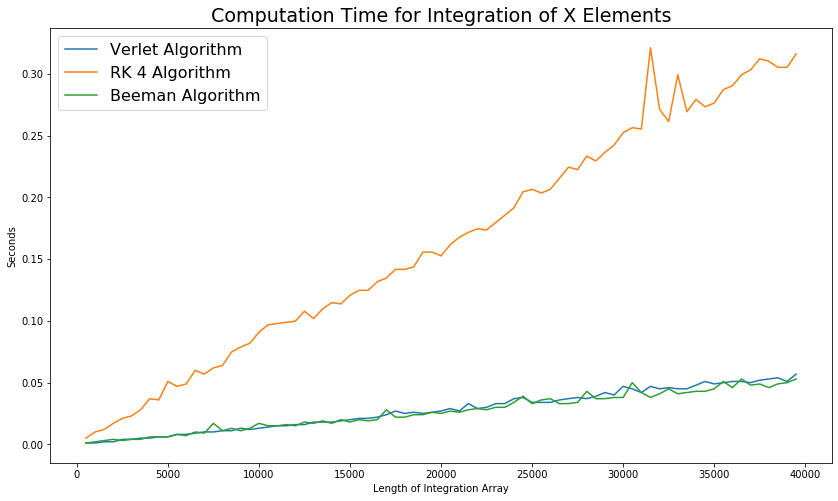

5.561039952355788


In [7]:
#plotting Data
fig, ax = plt.subplots(1,1,figsize=(14, 8))
font = {'size': 16}
plt.rc('font', **font)
plt.plot(n_range,verlet_data)
plt.plot(n_range,RK_4_data)
plt.plot(n_range,beeman_data)
plt.title('Computation Time for Integration of X Elements')
plt.ylabel('Seconds')
plt.xlabel('Length of Integration Array')
plt.legend(['Verlet Algorithm','RK 4 Algorithm','Beeman Algorithm'])

plt.show()

print(RK_4_data[-1]/verlet_data[-1])

From this, we can see that RK4 scales similarly to Beeman and Verlet functions, but takes  five and a half times as long. That may not be as significant as $O(n^2)$ vs $O(n)$, but when there are, for example, thousands of particles each interacting with eachother, or a dataset over a large portion of time, reducing the computation time by more than 5 times is convienient. 

Next, because Beeman and Verlet have similar time expenditures for a single computation, their accuracy will be evaluated.

In [8]:
full_x_range = 20.0
dt = 0.0001
N = int(full_x_range/dt)

#the function in RK format
def cosine(x,t):
    return -math.sin(t)

#the function in Verlet format
def cosine1(x,v,t):
    return -math.cos(t)


#baseline data to compare to
timeSet = np.arange(0,dt*N,dt)
baselineDataSet = np.array([math.cos(t) for t in timeSet])

#collecting data from each function
n_range = np.array(range(100,50000,100))
RK_4_data = RK_four(cosine,1.0,dt,N-1)[1]
verlet_data = verlet(cosine1,1.0,0.0,N-1,dt)[1]
beeman_data = beeman(cosine1,1.0,0.0,N-1,dt)[1]


C:\Users\relan\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


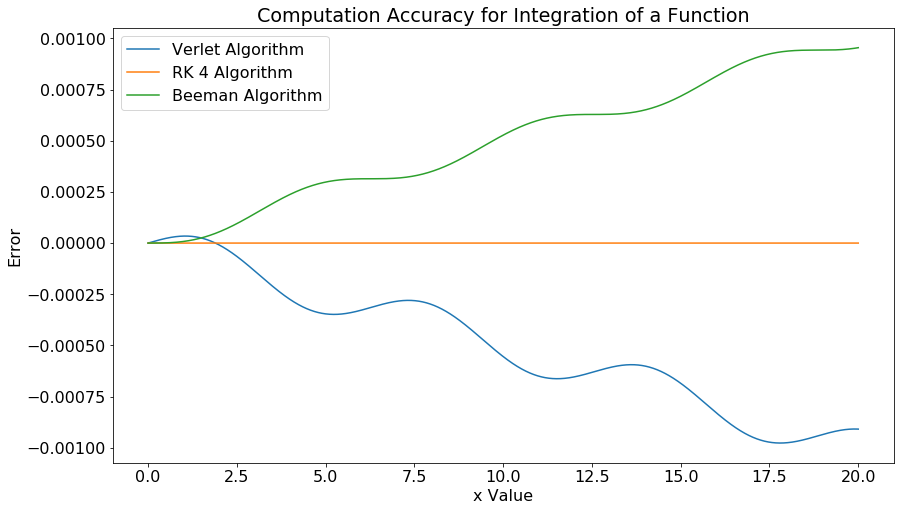

In [9]:
#plotting Data
fig, ax = plt.subplots(1,1,figsize=(14, 8))
plt.plot(timeSet,verlet_data - baselineDataSet)
plt.plot(timeSet,RK_4_data - baselineDataSet)
plt.plot(timeSet,beeman_data - baselineDataSet)
plt.title('Computation Accuracy for Integration of a Function')
plt.ylabel('Error')
plt.xlabel('x Value')
plt.legend(['Verlet Algorithm','RK 4 Algorithm','Beeman Algorithm'])

plt.show()


This seems to show that the errors between Verlet and Beeman integration algorithms (with the correction cycle only happening once in the Beeman Algorithm) are very close, scaling similarly. How do their velocity errors compare?

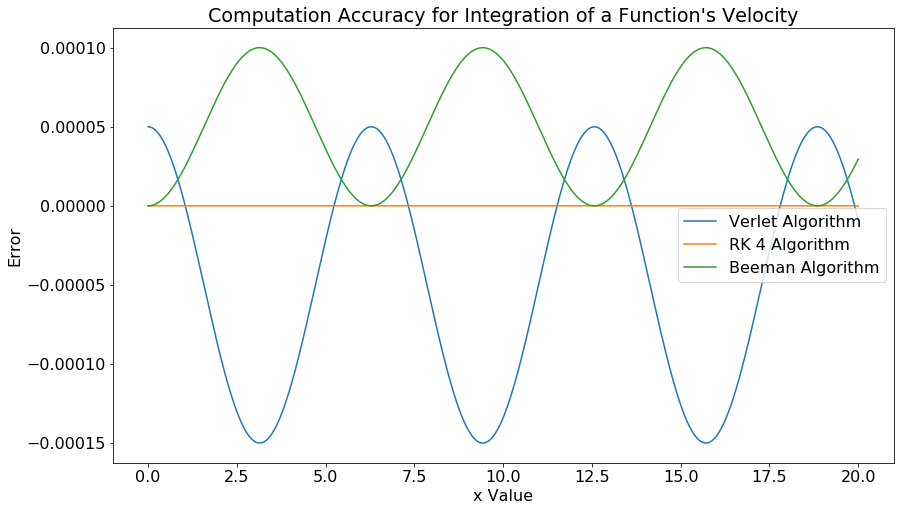

In [10]:
#calculating Velocity Data for each method
verlet_velocity = np.array([(verlet_data[i+1] - verlet_data[i] )/dt for i in range(len(verlet_data)-1)])
RK_fire = np.array([(RK_4_data[i+1] - RK_4_data[i] )/dt for i in range(len(RK_4_data)-1)])
Beeman_airspeed = np.array([(beeman_data[i+1] - beeman_data[i] )/dt for i in range(len(beeman_data)-1)])
baseline_velcity =  np.array([(baselineDataSet[i+1] - baselineDataSet[i] )/dt for i in range(len(baselineDataSet)-1)])

# Plotting Velocity Data
fig, ax = plt.subplots(1,1,figsize=(14, 8))
plt.plot(timeSet[:-1],verlet_velocity - baseline_velcity)
plt.plot(timeSet[:-1],RK_fire - baseline_velcity)
plt.plot(timeSet[:-1],Beeman_airspeed - baseline_velcity)
plt.title('Computation Accuracy for Integration of a Function\'s Velocity')
plt.ylabel('Error')
plt.xlabel('x Value')
plt.legend(['Verlet Algorithm','RK 4 Algorithm','Beeman Algorithm'])

plt.show()


Proof of the initial statement, the Beeman Algorithm is faster than the RK-4 method and has velocities consistently more accurate and precise than its counterpart, the Verlet Method, and with only one round of position correction in the algorithm. For large datasets, like would be produced if many many periods were to be calculated, the Beeman method is the supperior option.  

## Equations of Motion

The duffing equation in 3 dimensions is as follows, and picking constants creating a system with simple osillatory motion will be a test case for the creation of a pointcare section algorithm to follow. Fow now, the constants will be the same for each dimension.

$$ \ddot{x} = \gamma_x cos(\omega_x t) - \delta_x \dot{x} - \beta_x x - \alpha_x x^3 $$\
$$ \ddot{y} = \gamma_y cos(\omega_y t) - \delta_y \dot{x} - \beta_y x - \alpha_y x^3 $$\
$$ \ddot{z} = \gamma_z cos(\omega_z t) - \delta_z \dot{x} - \beta_z x - \alpha_z x^3 $$


In [86]:
#an SHO
_del = 0.0
alpha = 0.0
beta = 2.0
gamma = 0.0
omega = 0.0

#takes in a 1 by 6 list, x,y,z,vx,vy,vz, and the time t
def system_equation(f,t):
    x = f[0]
    y = f[1]
    z = f[2]
    v_x = f[3]
    v_y = f[4]
    v_z = f[5]
    return np.array([ v_x, v_y, v_z, gamma*math.cos(omega*t) -_del*v_x - beta*x - alpha*x**3, gamma*math.cos(omega*t) -_del*v_y - beta*y - alpha*y**3, gamma*math.cos(omega*t) -_del*v_z - beta*z - alpha*z**3])
    
#takes two 1x3 arrays, the first containing initial positions and the second initial velocities, and time t
def system_equation2(p,v,t):
    x = p[0]
    y = p[1]
    z = p[2]
    v_x = v[0]
    v_y = v[1]
    v_z = v[2]
    return np.array([ gamma*math.cos(omega*t) -_del*v_x - beta*x - alpha*x**3, gamma*math.cos(omega*t) -_del*v_y - beta*y - alpha*y**3, gamma*math.cos(omega*t) -_del*v_z - beta*z - alpha*z**3])

In [87]:
v_not = np.array([1.0,0.5,.25])
x_not = np.array([2.5,5.0,10.0])
data = beeman(system_equation2,x_not,v_not,10000,0.01)

#print(data[1])
xs = np.array([x[0] for x in data[1]])
ys = np.array([y[1] for y in data[1]])
zs = np.array([z[2] for z in data[1]])
#print(xs,ys,zs)

0.10705255323687914


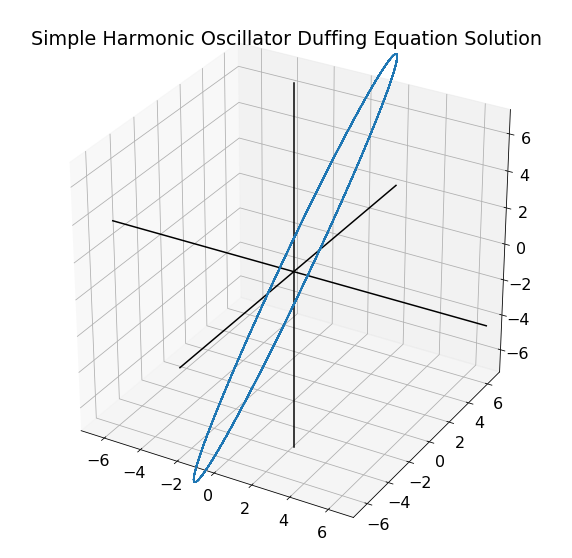

In [89]:
print(data[1][800][0])
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
#the wire represented by a black line

ax.plot(np.linspace(-10, 10, 100),[0]*100,[0]*100,color='black')
ax.plot([0]*100,np.linspace(-10, 10, 100),[0]*100,color='black')
ax.plot([0]*100,[0]*100,np.linspace(-10, 10, 100),color='black')
ax.set_xlim(-7,7)
ax.set_ylim(-7,7)
ax.set_zlim(-7,7)

ax.plot(xs,ys,zs)
plt.title('Simple Harmonic Oscillator Duffing Equation Solution')
plt.show()

#plt.plot(verlet(system_equation,x_not,v_not,1000,0.01)[1])

In [14]:
#Parameter Example sets

#an SHO
_del = 0.0
alpha = 0.0
beta = 2.0
gamma = 0.0
omega = 0.0

# a DSHO
_del = 0.3
alpha = 0.0
beta = 2.0
gamma = 0.0
omega = 0.0

#a DDSHO
_del = 0.3
alpha = 0.0
beta = 2.0
gamma = 1.0
omega = 2.0*math.pi

#I have several more from papers I'm looking through, will update

#### End of Weeks 1 and 2 (and a little into 2.5, I've been a little late)

These last two weeks I formulated the Beeman algorithm, tested it against currently known integrators, and then set up the 3-D Duffing Equation function with display. Also listed are a few different parameter value sets for systems with different characteristics that I can use for display and pointcare. 

The equations of motion for non-isotropic materials and for pointcare functions have been made and tested. Next I want to find pointcare sections of applications of the Duffing Equation.

## Pointcare Sections

Pointcare sections take one section of a 3d plot and plot the points of intersection between the 3 dimentional function and that plane, often interesting when complex orbits or chaos are involved. If there are two points visable, then its a periodic function, whereas if there's a closed loop visible, then $___$.

First thing, I need a better function for the Duffing system, one that does not assume isotropic material. Something like an orbit may be periodic in all axiis, but for example a 

In [106]:
#this assumes the planes are verticle, parralel to the z Axis
def pointCare(function,a,b,C,_del,alpha,beta,gamma,omega,x_not,v_not,dist=10000,dt=0.01):
    N = dist/dt           
                 
    xpoints, ypoints = np.array([0.0]), np.array([0.0])
    data = beeman(system_equation2,x_not,v_not,N,dt)
    hypothetical_pts = np.array([[0.0,0.0,0.0]])
    #finding all times the function passes though a plane
    for i in data[1]:
        x = i[0]
        y = i[1]
        z = i[2]
        #see if they fit on the plane. Unfortunately, can't start with an empty array first.
        if abs(a*x + b*y + C) <= 0.1:
            hypothetical_pts = np.append(hypothetical_pts,[i],axis=0)
            #The new horizontal axis uses the minimum distance from the point 0,0, to the entered equation of the plane-
            d_min = C/math.sqrt((a)**2 + (b)**2)
            #and the distance btween x=0,y=0 and the point- 
            distance_between_points = math.sqrt((x+20)**2 + (y+20)**2) - math.sqrt(800)

            #to calculate the perspective horizontal axis value if the z axis is depicted at the closest point to the plane
            x_prime = 0
            if abs(distance_between_points) > abs(d_min): #this is so the acos func doesnt throw a domain error
                x_prime = distance_between_points*math.sin(math.acos(d_min/distance_between_points))
            #new y axis is similar to the Z axis because I assumed the planes are parallel to the Z axis
            y_prime = z
            xpoints = np.append(xpoints,x_prime)
            ypoints = np.append(ypoints,y_prime)
    #if sum(abs(xpoints)) == 0.0 and sum(abs(ypoints)) == 0.0:
    #    print('Try a larger number range, none found in this plot')
    #    return xpoints, ypoints
    else:
        return xpoints, ypoints, hypothetical_pts[1:]
    
    
    

What I accomplished in the past week is more research and fixing what was not working beforehand- small errors in the Beeman algorithm and looking into applications took some time, thgouh senior project once again made progress slow. This week I need to finish week 3 and test pointcare, and then plot pointcare of various applications and find sections. This will be simple because I'm limiting the sections to planes parallel to the vetical axis, and have a number of papers to show good examples. If I have the time, I want to make a mesh that shows characteristics of an elastic solid under deformaiton with a non-linear spring constant, though I will have time to plot one point's reaction within the solid.

This example is of a simple periodic function, and we should expect 2 points visible on the pointcare section.

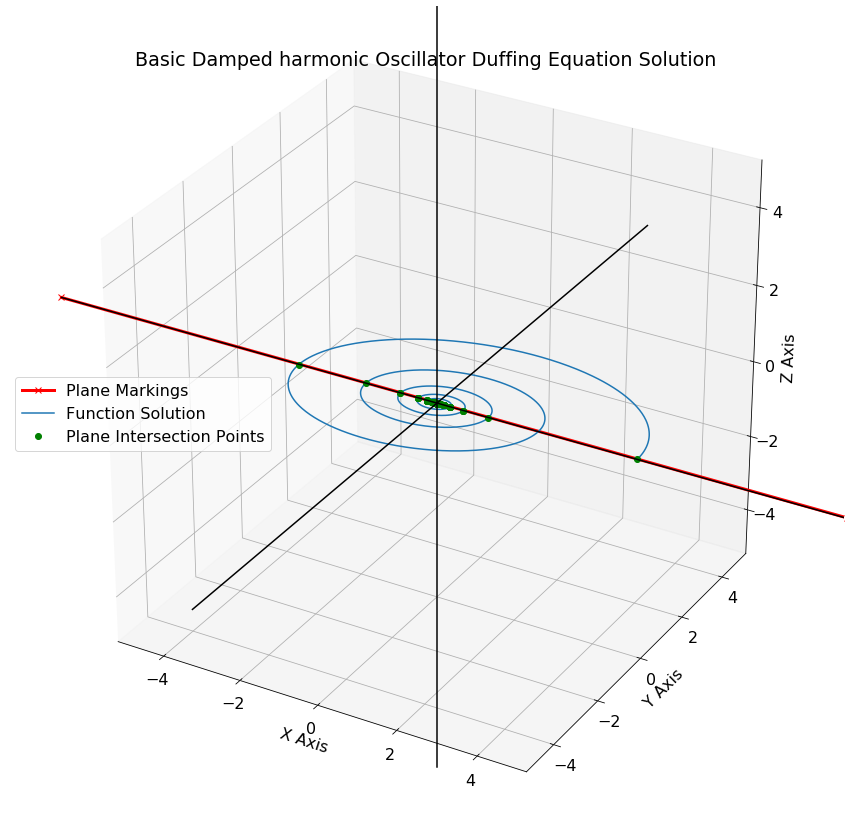

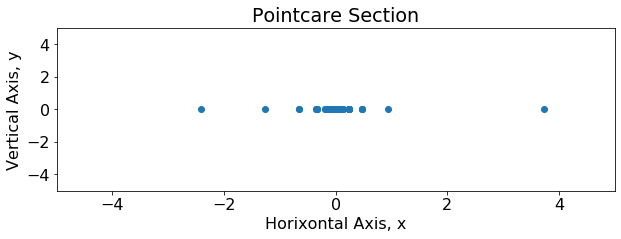

In [102]:
#testing the function after finishing it. There should be two points here because its periodic
_del = 0.3
alpha = 0.0
beta = 2.0
gamma = 0.0
omega = 0.0
#initial Conditions
v_not = np.array([0.0,5.0,0.0])
x_not = np.array([5.0,0.0,0.0])
def system_equation22(p,v,t):
    x = p[0]
    y = p[1]
    z = p[2]
    v_x = v[0]
    v_y = v[1]
    v_z = v[2]
    return np.array([ gamma*math.cos(omega*t) -_del*v_x - beta*x - alpha*x**3, gamma*math.cos(omega*t) -_del*v_y - beta*y - alpha*y**3, gamma*math.cos(omega*t) -_del*v_z - beta*z - alpha*z**3])

#plane conditions
a = .01 #controls plane's y intercept
b = -10. #controls plane's x intercept 
C = a*b

plot_data = beeman(system_equation22,x_not,v_not,10000,0.01)
section = pointCare(system_equation22,a,b,C,_del,alpha,beta,gamma,omega,x_not,v_not,1000)
#print(section[2])


#sectioning out coordinates into individual arrays for plotting
xs = np.array([x[0] for x in plot_data[1]])
ys = np.array([y[1] for y in plot_data[1]])
zs = np.array([z[2] for z in plot_data[1]])

#sectioning out points that are on the plane
other_xs = np.array([x[0] for x in section[2]])
other_ys = np.array([y[1] for y in section[2]])
other_zs = np.array([z[2] for z in section[2]])

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')

#the chosen plane represented in red
ax.plot([b,0,-b],[0,a,2*a],[0,0,0],marker='x',color='red',linewidth=3.0)
#plot the function
ax.plot(xs,ys,zs)
#plot where the function intersects with the plane
ax.plot(other_xs,other_ys,other_zs,linestyle='none',marker='o',color='green')
#axiis
ax.plot(np.linspace(-10, 10, 100),[0]*100,[0]*100,color='black')
ax.plot([0]*100,np.linspace(-10, 10, 100),[0]*100,color='black')
ax.plot([0]*100,[0]*100,np.linspace(-10, 10, 100),color='black')

#Labeling Plots
ax.legend(["Plane Markings","Function Solution","Plane Intersection Points"],loc=6)
ax.set_ylabel('Y Axis')
ax.set_xlabel('X Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_zlim(-5,5)

plt.title('Basic Damped harmonic Oscillator Duffing Equation Solution')
plt.show()

#the 2-d section that is a pointcare section
fig = plt.figure(figsize=(10,3))
plt.plot(section[0],section[1],linestyle='none',marker="o")
plt.xlabel('Horixontal Axis, x')
plt.ylabel('Vertical Axis, y')
plt.title("Pointcare Section")
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.show()

This next is a more complicated contrived example, also showing the complexity possible in the Duffing Equation.

In [107]:
#There should be many points here because Its driven and damped, and I need to make sure to use smaller velocities so
#that the point being measured are within the error provided in the pointcare section function
_del = 0.3
alpha = 0.2
beta = 2.0
gamma = 1.0
omega = 0.2
v_not = np.array([0.0,10.0,10.0])
x_not = np.array([10.,0.0,0.0])
def system_equation22(p,v,t):
    x = p[0]
    y = p[1]
    z = p[2]
    v_x = v[0]
    v_y = v[1]
    v_z = v[2]
    return np.array([ gamma*math.cos(omega*t) -_del*v_x - beta*x - alpha*x**3, gamma*math.cos(omega*t) -_del*v_y - beta*y - alpha*y**3, gamma*math.cos(omega*t) -_del*v_z - beta*z - alpha*z**3])

a = 10.#controls plane's y intercept
b = .1 #controls plane's x intercept
C = a*b

plot_data = beeman(system_equation22,x_not,v_not,10000,0.01)
section = pointCare(system_equation22,a,b,C,_del,alpha,beta,gamma,omega,x_not,v_not)
#print(section[2])


#sectioning out coordinates into individual arrays for plotting
xs = np.array([x[0] for x in plot_data[1]])
ys = np.array([y[1] for y in plot_data[1]])
zs = np.array([z[2] for z in plot_data[1]])

#sectioning out points that are on the plane
other_xs = np.array([x[0] for x in section[2]])
other_ys = np.array([y[1] for y in section[2]])
other_zs = np.array([z[2] for z in section[2]])


[[-0.09632853  0.33386834  0.33386834]
 [-0.10873034  0.65076393  0.65076393]
 [-0.09365707 -0.86764444 -0.86764444]
 ...
 [-0.10683363 -0.10683363 -0.10683363]
 [-0.10783199 -0.10783199 -0.10783199]
 [-0.10882986 -0.10882986 -0.10882986]]


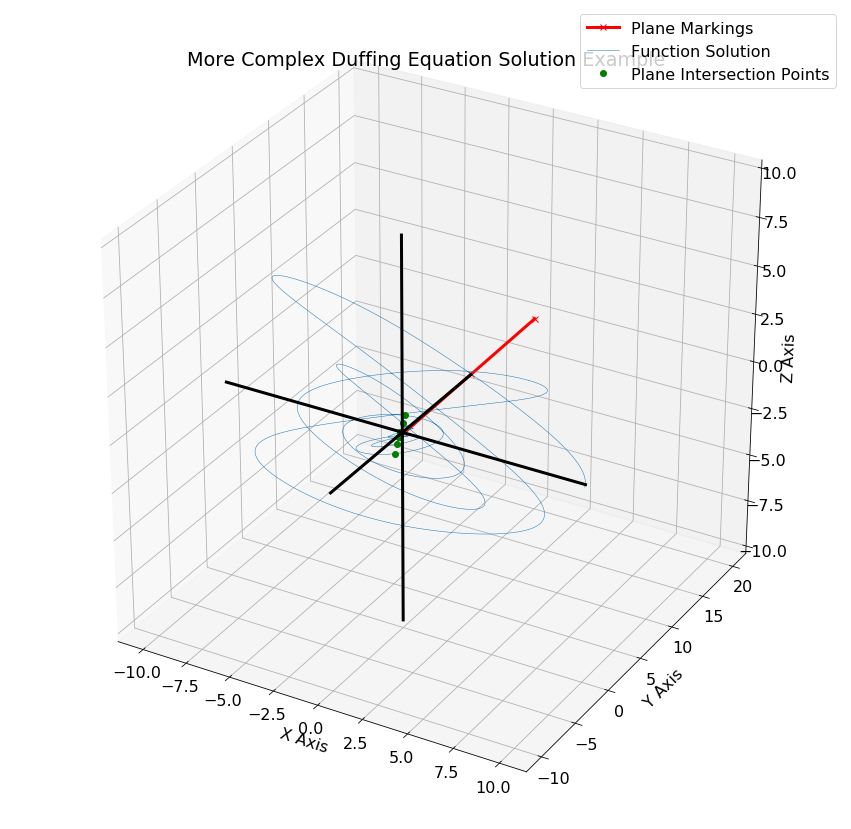

In [108]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')

#the plane selected represented by a red line
ax.plot([b,0,-b],[0,a,2*a],[0,0,0],marker='x',color='red',linewidth=3.0)

#plot the function
ax.plot(xs,ys,zs,linewidth=0.5)
#plot where the function intersects with the plane
ax.plot(other_xs,other_ys,other_zs,linestyle='none',marker='o',color='green')

ax.plot(np.linspace(-10, 10, 100),[0]*100,[0]*100,color='black',linewidth=3.0)
ax.plot([0]*100,np.linspace(-10, 10, 100),[0]*100,color='black',linewidth=3.0)
ax.plot([0]*100,[0]*100,np.linspace(-10, 10, 100),color='black',linewidth=3.0)

#Labeling Plots
ax.legend(["Plane Markings","Function Solution","Plane Intersection Points"],loc=6)
ax.set_ylabel('Y Axis')
ax.set_xlabel('X Axis')
ax.set_zlabel('Z Axis')
plt.title('More Complex Duffing Equation Solution Example')
plt.show()

This is the 3d plot showing the intersection points with the the chosen plane, marked with red X's from its intersection points on the x and y axis.

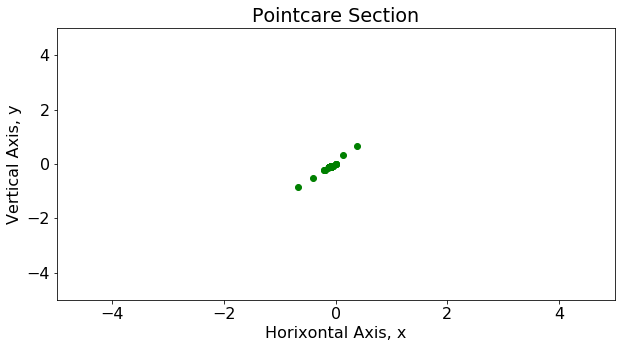

In [109]:
fig = plt.figure(figsize=(10,5))
plt.plot(section[0],section[1],linestyle='none',marker="o",color='green')
plt.xlabel('Horixontal Axis, x')
plt.ylabel('Vertical Axis, y')
plt.title("Pointcare Section")
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.show()

This is the 2-D plot of the algorithm, converting the points to the perspective looking straight at the plane.

## Different Cases to Test

The point of this project is to find a number of applications to test, observing Duffing applications and seeing its diverse utility. To follow is a brief explination of several applications, and the parameters they used in their models, if posisble. I hope to plot these in 3-space and if interesting enough, to pick a plane to plot it on.

#### Continuum Elastic Modeling of Graphene Resonators 

"modeling the mechanical properties of suspended graphene sheets. We find that already for deflections of the order of 0.5 Å a theory that correctly accounts for nonlinearities is necessary and that for many purposes a set of coupled Duffing-type equations may be used to accurately describe the dynamics of graphene membranes. " https://pubs.acs.org/doi/10.1021/nl801733d

The model this uses is derrived from combining the strain tensor relations and minimizing the free energy functional, basically a valence force field model. 

$$ \ddot{\bar{u}}(x,y) + \dot{\bar{u}}(x,y) = \rho_0^{-1}\mathscr{D}\hat{P}[\bar{u}(x,y)] + m_c^{-1}\bar{F}_0(x,y,t)$$

Obviously this is a 2-D space model, which can be plotted as 3-D if time is included as an axis.

#### Discretization of forced Duffing system with fractional-order damping

"fractional-order damping in the forced Duffing oscillator before and after applying a discretization process to it. Fixed points and their stability are discussed for the discrete system obtained. Finally, numerical simulations using Matlab are carried out to investigate the dynamic behavior such as bifurcation, chaos, and chaotic attractors. We note that on increasing the value of the fractional-order parameter, the resulting discrete system is stabilized." https://advancesindifferenceequations.springeropen.com/articles/10.1186/1687-1847-2014-66

Defigning $D^\alpha f(t)$ as $I^{1-\alpha}\frac{df(t)}{dt}$:

 $$ D^\alpha x = y $$\
 $$ D^{1-\alpha}y = z $$\
 $$ \frac{dz}{dt} = - \mu y - \lambda x - b x^3 + \gamma cos(\omega t)$$

In [ ]:
#Example Parameters for this system:
alpha = 0.85
mu = 0.9
llambda = -1.0
b = 1.0
gamma = 0.6
omega = 1.0

#### Arnold-Beltrami-Childress (ABC) Flow

This is used to model chaos of the three-dimensional Euler equations in laminar fluid flows. In this case, its not the Euler method of integration but the Euler method of observing fluid mechanics; looking at the velocity field rather than the lath of a partcle. This solution exhibits chaos, with the parameters:

In [110]:
#Example Parameters for this system:
_del = 0.15
alpha = 1.0
beta = 1.0
gamma = 0.3
omega = 1.0

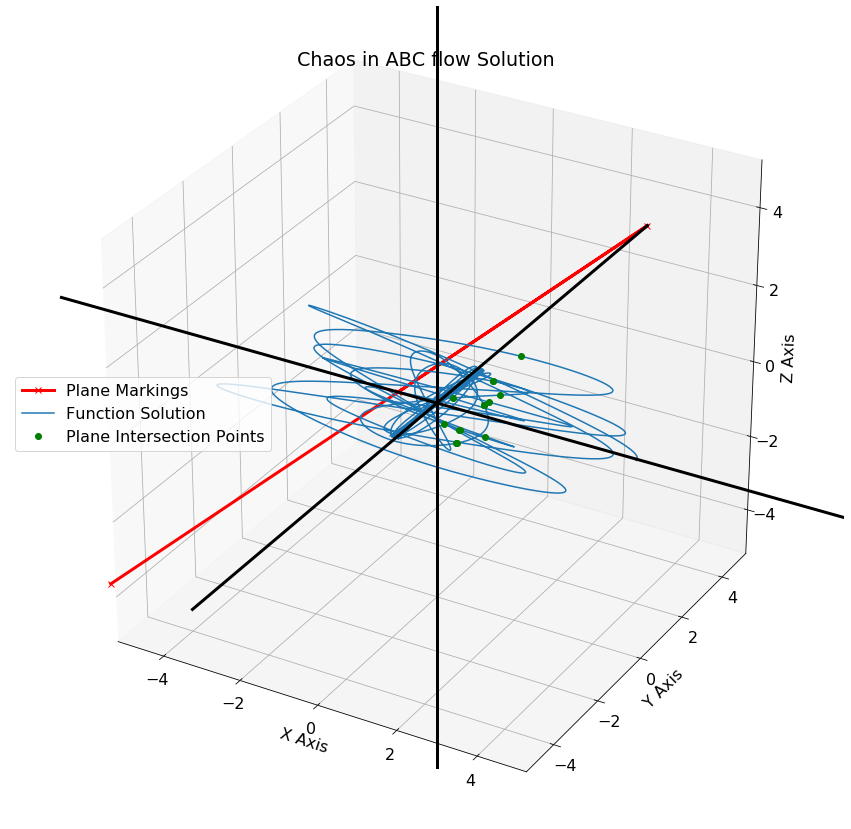

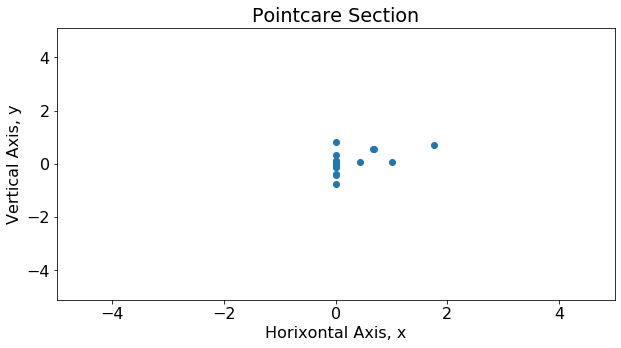

In [121]:
#initial Conditions
v_not = np.array([0.0,5.0,0.0])
x_not = np.array([5.0,0.0,0.0])
def system_equation22(p,v,t):
    x = p[0]
    y = p[1]
    z = p[2]
    v_x = v[0]
    v_y = v[1]
    v_z = v[2]
    return np.array([ gamma*math.cos(omega*t) -_del*v_x - beta*x - alpha*x**3, gamma*math.cos(omega*t) -_del*v_y - beta*y - alpha*y**3, gamma*math.cos(omega*t) -_del*v_z - beta*z - alpha*z**3])

#plane conditions
a = 10. #controls plane's y intercept
b = -1.0 #controls plane's x intercept 
C = a*b

plot_data = beeman(system_equation22,x_not,v_not,10000,0.01)
section = pointCare(system_equation22,a,b,C,_del,alpha,beta,gamma,omega,x_not,v_not,10000,0.005)
#print(section[2])


#sectioning out coordinates into individual arrays for plotting
xs = np.array([x[0] for x in plot_data[1]])
ys = np.array([y[1] for y in plot_data[1]])
zs = np.array([z[2] for z in plot_data[1]])

#sectioning out points that are on the plane
other_xs = np.array([x[0] for x in section[2]])
other_ys = np.array([y[1] for y in section[2]])
other_zs = np.array([z[2] for z in section[2]])

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')

#the plane represented by a red line
ax.plot([b,0,2*b],[0,a,-a],[0,0,0],marker='x',color='red',linewidth=3.0)
#plot the function
ax.plot(xs,ys,zs)
#plot where the function intersects with the plane
ax.plot(other_xs,other_ys,other_zs,linestyle='none',marker='o',color='green')
#axiis
ax.plot(np.linspace(-10, 10, 100),[0]*100,[0]*100,color='black',linewidth=3.0)
ax.plot([0]*100,np.linspace(-10, 10, 100),[0]*100,color='black',linewidth=3.0)
ax.plot([0]*100,[0]*100,np.linspace(-10, 10, 100),color='black',linewidth=3.0)

#Labeling Plots
ax.legend(["Plane Markings","Function Solution","Plane Intersection Points"],loc=6)
ax.set_ylabel('Y Axis')
ax.set_xlabel('X Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_zlim(-5,5)

plt.title('Chaos in ABC flow Solution')
plt.show()

#the 2-d section that is a pointcare section
fig = plt.figure(figsize=(10,5))
plt.plot(section[0],section[1],linestyle='none',marker="o")
plt.xlabel('Horixontal Axis, x')
plt.ylabel('Vertical Axis, y')
plt.title("Pointcare Section")
plt.xlim([-5,5])
plt.ylim([-5.1,5.1])
plt.show()

If this is allowed to continue for large time scales, Many solutions produce interesting plots like this the below- This is unfortnately past my computational abilities at the moment due to my pointcare section algorithm being $O(n^2)$.
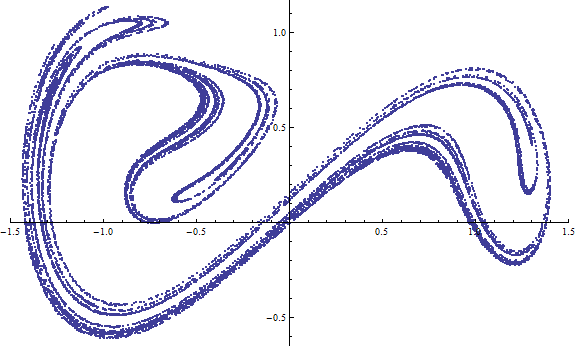



Overall, I'd like to have done a little more with this project. The Pointcare could have been shortened as meantioned in by poster, by both creating the points and checking if they're on the plane in the same step, and during this using a variable time step.

Additionally, I'd have liked to find a few more visual applications, like origionally I wanted to make a mesh and show the Duffing equation modeling a solid, like jello, that displaces easily and then hardens. 

I had a large amount of trouble with the sign of the Pointcare function, as finding the distance of the x prime axis drove me to shift everything, calculate it, and then shift it back. This project was pretty neat, but I'd like to have a few more interesting visuals and tests.